In [1]:
import os
os.environ["HF_HUB_ENABLE_PICKLE_EXPERIMENTAL"] = "1"
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Any

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm

from diffusers import StableDiffusionInpaintPipeline, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

from peft import LoraConfig
from peft.utils import get_peft_model_state_dict

c:\Users\SyedM\miniconda3\envs\lora_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# Config
# -----------------------------
@dataclass
class TrainConfig:
    model_id: str = "stable-diffusion-v1-5/stable-diffusion-inpainting"
    base_dir: Path = Path(".")
    image_size: int = 512

    train_batch_size: int = 2
    num_epochs: int = 1
    max_train_steps: int = 2000
    learning_rate: float = 1e-4  # LoRA often tolerates higher LR than full finetune
    lr_warmup_steps: int = 50
    gradient_accumulation_steps: int = 1
    max_grad_norm: float = 1.0

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    mixed_precision: str = "fp16"  # "fp16" or "bf16"

    output_dir: Path = Path("lora_inpainting")
    seed: int = 42

cfg = TrainConfig()
cfg.output_dir.mkdir(parents=True, exist_ok=True)


In [3]:
# -----------------------------
# Dataset
# -----------------------------
class InpaintingLoraDataset(Dataset):
    def __init__(self, base_dir: Path, image_size: int = 512):
        self.prepared_dir = base_dir / "prepared"
        self.orig_dir = self.prepared_dir / "original"
        self.dmg_dir = self.prepared_dir / "inpainting" / "input"
        self.mask_dir = self.prepared_dir / "inpainting" / "mask"
        self.image_size = image_size

        self.files: List[Path] = sorted(
            f for f in self.orig_dir.iterdir()
            if f.suffix.lower() in {".png", ".jpg", ".jpeg"}
            and (self.dmg_dir / f.name).exists()
            and (self.mask_dir / f.name).exists()
        )

        self.img_tf = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),  # [0,1]
        ])
        self.to_sd = transforms.Normalize([0.5, 0.5, 0.5],
                                          [0.5, 0.5, 0.5])  # -> [-1,1]

        self.prompt = (
            "restore the missing regions realistically, "
            "continuous surfaces, natural textures, "
            "matching colors and lighting, no text, no watermark"
        )

        self.mask_resize = transforms.Resize(
            (image_size, image_size),
            interpolation=transforms.InterpolationMode.NEAREST
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx].name
        orig = Image.open(self.orig_dir / fname).convert("RGB")
        dmg = Image.open(self.dmg_dir / fname).convert("RGB")
        mask = Image.open(self.mask_dir / fname).convert("L")

        orig = self.to_sd(self.img_tf(orig))
        dmg = self.to_sd(self.img_tf(dmg))

        mask = self.mask_resize(mask)
        mask = transforms.ToTensor()(mask)  # [1,H,W], 0..1

        # binarize just in case
        mask = (mask > 0.5).float()

        return {
            "original": orig,
            "damaged": dmg,
            "mask": mask,
            "prompt": self.prompt,
            "fname": fname,
        }



In [4]:
# -----------------------------
# Setup
# -----------------------------
torch.manual_seed(cfg.seed)

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    cfg.model_id,
    torch_dtype=torch.float16 if (cfg.device == "cuda" and cfg.mixed_precision == "fp16") else torch.float32,
)
pipe.to(cfg.device)

unet = pipe.unet
vae = pipe.vae
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer

# IMPORTANT: training noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(cfg.model_id, subfolder="scheduler")  # :contentReference[oaicite:2]{index=2}

# Freeze base weights
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Add LoRA (PEFT)
unet_lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)
unet.add_adapter(unet_lora_config)  # official pattern :contentReference[oaicite:3]{index=3}

# Upcast trainable LoRA params to fp32 for stability if using fp16
trainable_params = []
for p in unet.parameters():
    if p.requires_grad:
        p.data = p.data.to(torch.float32)
        trainable_params.append(p)

print("Trainable LoRA params:", sum(p.numel() for p in trainable_params))


dataset = InpaintingLoraDataset(cfg.base_dir, cfg.image_size)
print("Dataset size:", len(dataset))

train_loader = DataLoader(
    dataset,
    batch_size=cfg.train_batch_size,
    shuffle=True,
    num_workers=0,  # safest in Windows notebooks
)

optimizer = torch.optim.AdamW(trainable_params, lr=cfg.learning_rate)

# compute training steps correctly
steps_per_epoch = max(1, len(train_loader) // cfg.gradient_accumulation_steps)
max_train_steps = min(cfg.max_train_steps, cfg.num_epochs * steps_per_epoch)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=cfg.lr_warmup_steps,
    num_training_steps=max_train_steps,
)

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=(cfg.device == "cuda" and cfg.mixed_precision == "fp16"))


def encode_latents(img: torch.Tensor) -> torch.Tensor:
    img = img.to(cfg.device, dtype=vae.dtype)
    latents = vae.encode(img).latent_dist.sample()
    latents = latents * 0.18215
    return latents


Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:01,  4.28it/s]An error occurred while trying to fetch C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  71%|███████▏  | 5/7 [00:00<00:00, 13.88it/s]An error occurred while trying to fetch C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5

Trainable LoRA params: 1594368
Dataset size: 92858


C:\Users\SyedM\AppData\Local\Temp\ipykernel_11132\321475567.py:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(cfg.device == "cuda" and cfg.mixed_precision == "fp16"))


In [5]:
# -----------------------------
# Training loop
# -----------------------------
unet.train()
global_step = 0
progress = tqdm(total=max_train_steps, desc="LoRA Inpaint Training")

optimizer.zero_grad(set_to_none=True)

for epoch in range(cfg.num_epochs):
    for batch in train_loader:
        if global_step >= max_train_steps:
            break

        with torch.no_grad():
            orig = batch["original"].to(cfg.device)
            dmg = batch["damaged"].to(cfg.device)
            mask = batch["mask"].to(cfg.device)
            prompts = batch["prompt"]

            with autocast(enabled=(cfg.device == "cuda")):
                orig_latents = encode_latents(orig)
                dmg_latents = encode_latents(dmg)

            noise = torch.randn_like(orig_latents)
            bsz = orig_latents.shape[0]
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,),
                device=orig_latents.device, dtype=torch.long
            )

            noisy_latents = noise_scheduler.add_noise(orig_latents, noise, timesteps)

            mask_latents = torch.nn.functional.interpolate(
                mask, size=noisy_latents.shape[-2:], mode="nearest"
            )

            # SD inpaint UNet expects 9 channels input:
            # [noisy_latents (4), mask (1), masked_image_latents (4)]
            latent_model_input = torch.cat([noisy_latents, mask_latents, dmg_latents], dim=1)

            text_inputs = tokenizer(
                prompts,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            )
            text_emb = text_encoder(text_inputs.input_ids.to(cfg.device))[0]

        with autocast(enabled=(cfg.device == "cuda")):
            model_pred = unet(
                latent_model_input,
                timesteps,
                encoder_hidden_states=text_emb,
            ).sample

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(orig_latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction_type {noise_scheduler.config.prediction_type}")

            loss = nn.functional.mse_loss(model_pred.float(), target.float(), reduction="mean")
            loss = loss / cfg.gradient_accumulation_steps

        scaler.scale(loss).backward()

        # step only on accumulation boundary
        if (global_step + 1) % cfg.gradient_accumulation_steps == 0:
            # unscale -> clip -> step
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(trainable_params, cfg.max_grad_norm)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            lr_scheduler.step()  # <-- you were missing this

        global_step += 1
        progress.update(1)
        progress.set_postfix(loss=float(loss.item() * cfg.gradient_accumulation_steps))

progress.close()
print("Training complete. Global steps:", global_step)

LoRA Inpaint Training:   0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\SyedM\AppData\Local\Temp\ipykernel_11132\1198057594.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(cfg.device == "cuda")):
C:\Users\SyedM\AppData\Local\Temp\ipykernel_11132\1198057594.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(cfg.device == "cuda")):
LoRA Inpaint Training: 100%|██████████| 2000/2000 [11:09<00:00,  2.99it/s, loss=0.0486]  

Training complete. Global steps: 2000


In [6]:
# -----------------------------
# Save LoRA weights
# -----------------------------
unet_lora_state_dict = get_peft_model_state_dict(unet)

StableDiffusionInpaintPipeline.save_lora_weights(
    save_directory=cfg.output_dir,
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True
)
print("Saved LoRA weights to:", cfg.output_dir)


Saved LoRA weights to: lora_inpainting


In [7]:
# Cell 9 (Improved): Load base & LoRA pipelines for comparison

import os
import torch
from diffusers import StableDiffusionInpaintPipeline

# Reuse env flags
os.environ["HF_HUB_ENABLE_PICKLE_EXPERIMENTAL"] = "1"
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

device = cfg.device
model_id = cfg.model_id
lora_dir = cfg.output_dir

dtype = torch.float16 if device == "cuda" else torch.float32

# Base pipeline (no LoRA)
pipe_base = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    torch_dtype=dtype,
).to(device)

# LoRA pipeline
pipe_lora = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    torch_dtype=dtype,
).to(device)

# Load LoRA weights
pipe_lora.load_lora_weights(lora_dir)

# Optional performance tweaks
for p in (pipe_base, pipe_lora):
    try:
        p.enable_attention_slicing()
    except Exception:
        pass
    if device == "cuda":
        try:
            p.enable_xformers_memory_efficient_attention()
        except Exception:
            pass

# Optional: disable safety checker for local experiments
# (only if your environment allows it and you're not deploying)
try:
    pipe_base.safety_checker = None
    pipe_lora.safety_checker = None
except Exception:
    pass

print("Base and LoRA pipelines ready on", device)
print("LoRA directory:", lora_dir)


Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:01,  3.48it/s]An error occurred while trying to fetch C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  71%|███████▏  | 5/7 [00:00<00:00, 11.58it/s]An error occurred while trying to fetch C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5

Base and LoRA pipelines ready on cuda
LoRA directory: lora_inpainting


In [8]:
# Cell 10 (Improved): Pick random test images (deterministic)

import random
from pathlib import Path

base_dir = cfg.base_dir

prepared_dir = base_dir / "prepared"
orig_dir = prepared_dir / "original"
dmg_dir = prepared_dir / "inpainting" / "input"
mask_dir = prepared_dir / "inpainting" / "mask"

all_damaged = sorted(
    f for f in dmg_dir.iterdir()
    if f.suffix.lower() in {".png", ".jpg", ".jpeg"}
    and (mask_dir / f.name).exists()
    and (orig_dir / f.name).exists()
)

print("Total pairs available:", len(all_damaged))

# Reproducible sample list
random.seed(123)
num_samples = 12  # keep smaller for faster interactive runs
sample_files = random.sample(all_damaged, min(num_samples, len(all_damaged)))

print("Sampling:")
for p in sample_files:
    print(" -", p.name)


Total pairs available: 92858
Sampling:
 - test-00001-of-00028_003291.png
 - test-00009-of-00028_002936.png
 - test-00003-of-00028_000711.png
 - test-00014-of-00028_003371.png
 - test-00009-of-00028_002789.png
 - test-00003-of-00028_003400.png
 - test-00001-of-00028_001428.png
 - test-00013-of-00028_003257.png
 - test-00019-of-00028_002420.png
 - test-00020-of-00028_002272.png
 - test-00012-of-00028_000677.png
 - test-00012-of-00028_001805.png


100%|██████████| 28/28 [00:01<00:00, 15.89it/s]


  Masked   Base PSNR=16.77 SSIM=0.882 | LoRA PSNR=16.99 SSIM=0.887
  Global   Base PSNR=23.51 SSIM=0.763 | LoRA PSNR=23.54 SSIM=0.763
File: test-00001-of-00028_003291.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


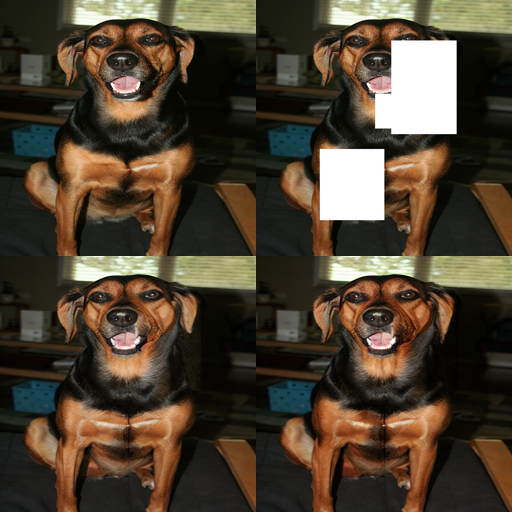

100%|██████████| 28/28 [00:01<00:00, 15.91it/s]


  Masked   Base PSNR=10.54 SSIM=0.775 | LoRA PSNR=10.32 SSIM=0.776
  Global   Base PSNR=12.78 SSIM=0.284 | LoRA PSNR=12.62 SSIM=0.282
File: test-00009-of-00028_002936.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


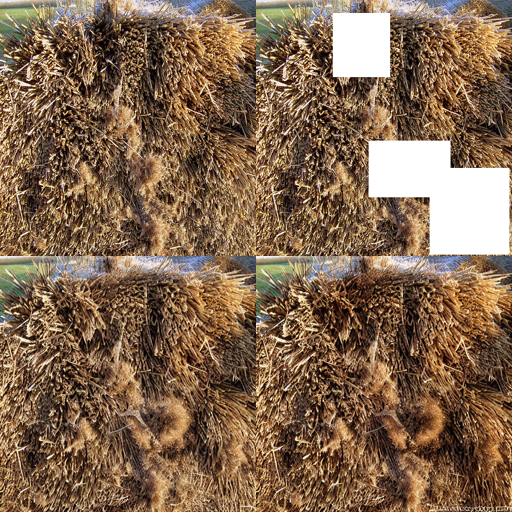

100%|██████████| 28/28 [00:01<00:00, 15.72it/s]


  Masked   Base PSNR=11.27 SSIM=0.828 | LoRA PSNR=11.41 SSIM=0.830
  Global   Base PSNR=15.49 SSIM=0.437 | LoRA PSNR=15.51 SSIM=0.437
File: test-00003-of-00028_000711.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


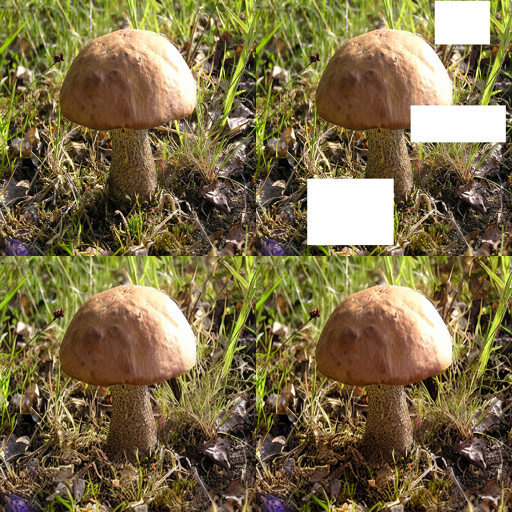

100%|██████████| 28/28 [00:01<00:00, 15.87it/s]


  Masked   Base PSNR=12.46 SSIM=0.815 | LoRA PSNR=13.31 SSIM=0.843
  Global   Base PSNR=18.49 SSIM=0.732 | LoRA PSNR=19.25 SSIM=0.752
File: test-00014-of-00028_003371.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


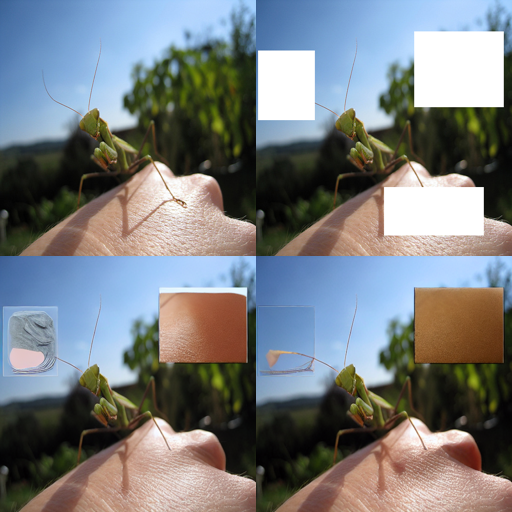

100%|██████████| 28/28 [00:01<00:00, 15.92it/s]


  Masked   Base PSNR=21.60 SSIM=0.896 | LoRA PSNR=14.41 SSIM=0.888
  Global   Base PSNR=26.42 SSIM=0.742 | LoRA PSNR=21.76 SSIM=0.732
File: test-00009-of-00028_002789.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


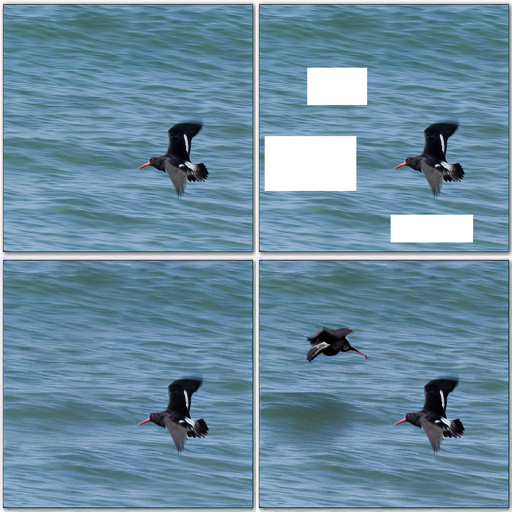

100%|██████████| 28/28 [00:01<00:00, 15.82it/s]


  Masked   Base PSNR=9.73 SSIM=0.896 | LoRA PSNR=8.51 SSIM=0.883
  Global   Base PSNR=18.12 SSIM=0.721 | LoRA PSNR=16.91 SSIM=0.700
File: test-00003-of-00028_003400.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


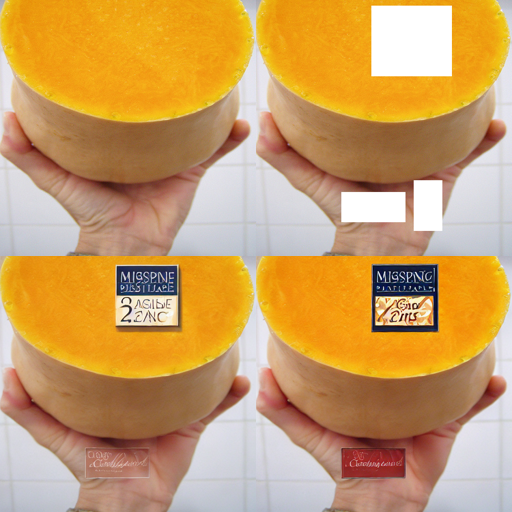

100%|██████████| 28/28 [00:01<00:00, 15.96it/s]


  Masked   Base PSNR=7.25 SSIM=0.825 | LoRA PSNR=9.55 SSIM=0.827
  Global   Base PSNR=14.56 SSIM=0.548 | LoRA PSNR=16.73 SSIM=0.530
File: test-00001-of-00028_001428.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


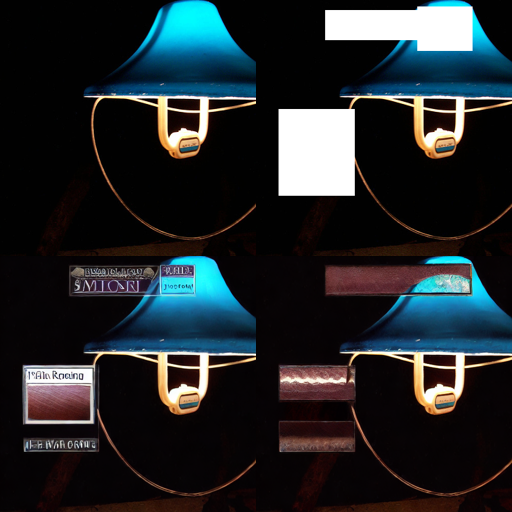

100%|██████████| 28/28 [00:01<00:00, 15.44it/s]


  Masked   Base PSNR=13.08 SSIM=0.810 | LoRA PSNR=11.74 SSIM=0.796
  Global   Base PSNR=18.16 SSIM=0.609 | LoRA PSNR=16.94 SSIM=0.592
File: test-00013-of-00028_003257.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


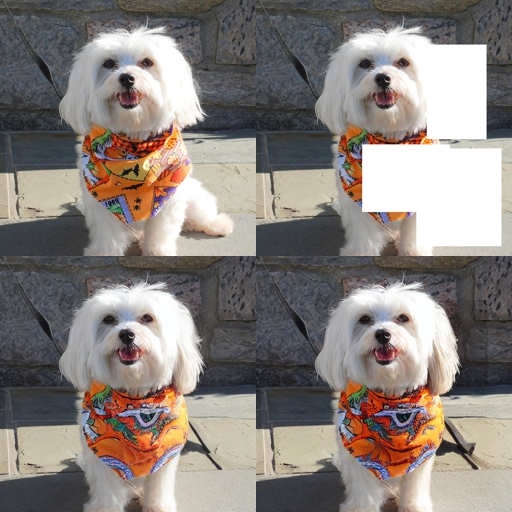

100%|██████████| 28/28 [00:01<00:00, 15.03it/s]


  Masked   Base PSNR=11.63 SSIM=0.854 | LoRA PSNR=17.30 SSIM=0.886
  Global   Base PSNR=19.08 SSIM=0.742 | LoRA PSNR=23.79 SSIM=0.772
File: test-00019-of-00028_002420.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


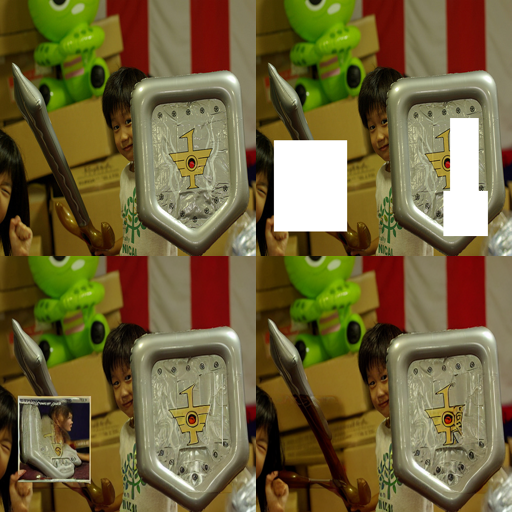

100%|██████████| 28/28 [00:01<00:00, 16.25it/s]


  Masked   Base PSNR=12.76 SSIM=0.854 | LoRA PSNR=11.28 SSIM=0.846
  Global   Base PSNR=18.87 SSIM=0.770 | LoRA PSNR=17.52 SSIM=0.757
File: test-00020-of-00028_002272.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


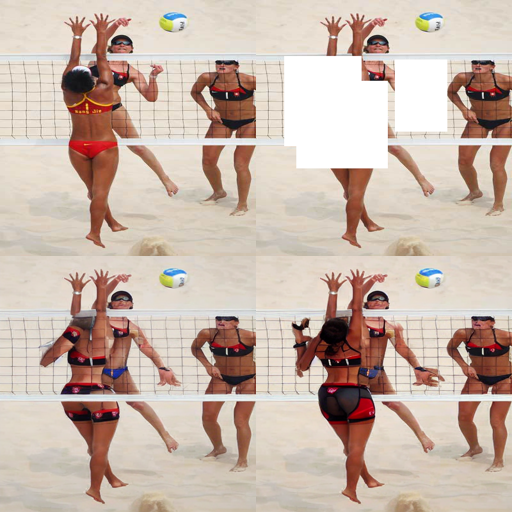

100%|██████████| 28/28 [00:01<00:00, 16.88it/s]


  Masked   Base PSNR=18.48 SSIM=0.953 | LoRA PSNR=15.81 SSIM=0.947
  Global   Base PSNR=24.26 SSIM=0.800 | LoRA PSNR=23.01 SSIM=0.791
File: test-00012-of-00028_000677.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


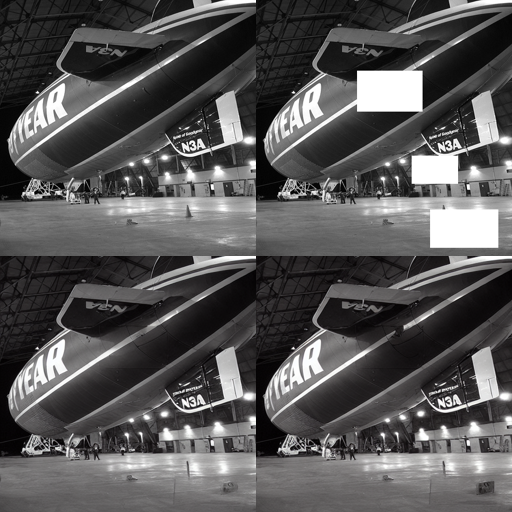

100%|██████████| 28/28 [00:01<00:00, 17.30it/s]


  Masked   Base PSNR=15.62 SSIM=0.878 | LoRA PSNR=10.33 SSIM=0.844
  Global   Base PSNR=20.47 SSIM=0.829 | LoRA PSNR=15.38 SSIM=0.790
File: test-00012-of-00028_001805.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


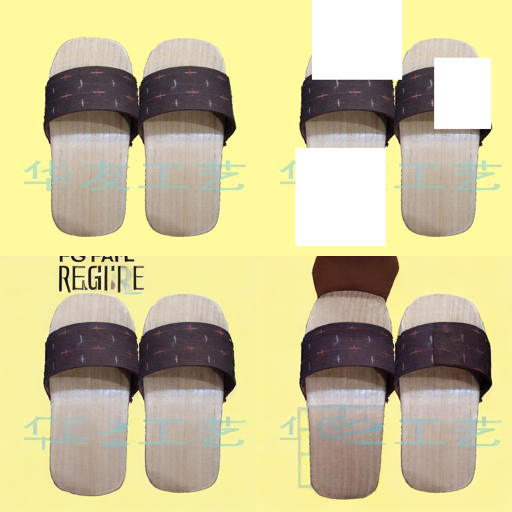

In [9]:
# Cell 11: Run base + LoRA inpainting + masked metrics + DISPLAY side-by-side

import numpy as np
import torch
from PIL import Image
from IPython.display import display
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -----------------------------
# Prompts / inference settings
# -----------------------------
clean_prompt = (
    "restore the missing regions realistically, "
    "continuous surfaces, natural textures, matching colors, "
    "similar lighting, similar background, no text, no watermark"
)

negative_prompt = (
    "text, letters, watermark, logo, caption, subtitles, UI, user interface, random characters, "
    "colored blocks, script, computer window, dialog box, buttons, icons, menu bar, sign, poster, "
    "bad artifacts, low quality, deformed, blurry, cropped, ugly"
)

num_inference_steps = 28
guidance_scale = 6
seed = 12345  # fixed seed so base vs LoRA comparable

# If you did NOT fuse LoRA, you can adjust scale here
lora_scale = 1.0

# -----------------------------
# Helper: global metrics (optional)
# -----------------------------
def global_metrics(pred: Image.Image, gt: Image.Image):
    if pred.size != gt.size:
        gt = gt.resize(pred.size, resample=Image.LANCZOS)

    p = np.array(pred).astype(np.float32)
    g = np.array(gt).astype(np.float32)

    psnr = peak_signal_noise_ratio(g, p, data_range=255)
    ssim = structural_similarity(g, p, channel_axis=2, data_range=255)
    return psnr, ssim

# -----------------------------
# Helper: masked metrics (recommended)
# -----------------------------
def masked_metrics(pred: Image.Image, gt: Image.Image, mask: Image.Image):
    """
    Computes:
    - Masked PSNR on only the inpaint region pixels
    - Focused SSIM using a proxy that highlights the inpaint area

    Mask semantics:
    - White/1 = region to inpaint (evaluate here)
    """

    # Align sizes to prediction
    if gt.size != pred.size:
        gt = gt.resize(pred.size, resample=Image.LANCZOS)
    if mask.size != pred.size:
        mask = mask.resize(pred.size, resample=Image.NEAREST)

    # Convert to arrays
    p = np.array(pred).astype(np.float32)
    g = np.array(gt).astype(np.float32)

    # Mask to {0,1}
    m = np.array(mask.convert("L")).astype(np.float32) / 255.0
    m = (m > 0.5).astype(np.float32)  # binarize

    # If mask is too small/empty, fall back to global
    if m.sum() < 10:
        psnr = peak_signal_noise_ratio(g, p, data_range=255)
        ssim = structural_similarity(g, p, channel_axis=2, data_range=255)
        return psnr, ssim

    # Expand mask to 3 channels
    m3 = np.repeat(m[..., None], 3, axis=2)

    # Extract masked pixels for PSNR
    p_masked = p[m3 == 1].reshape(-1, 3)
    g_masked = g[m3 == 1].reshape(-1, 3)

    mse = np.mean((p_masked - g_masked) ** 2)
    psnr = float("inf") if mse == 0 else 20 * np.log10(255.0 / np.sqrt(mse))

    # Focused SSIM proxy:
    # Replace unmasked area in pred with GT so SSIM is driven mainly by mask region
    p_focus = p * m3 + g * (1 - m3)
    ssim = structural_similarity(g, p_focus, channel_axis=2, data_range=255)

    return psnr, ssim

# -----------------------------
# Helper: run inpaint
# -----------------------------
def run_inpaint(pipe, damaged, mask, prompt, negative, steps, guidance, seed):
    gen = torch.Generator(device=device).manual_seed(seed)

    # If LoRA is loaded but not fused, you can control scale:
    if hasattr(pipe, "set_adapters"):
        try:
            pipe.set_adapters(["default"], [lora_scale])
        except Exception:
            pass

    out = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=damaged,
        mask_image=mask,
        num_inference_steps=steps,
        guidance_scale=guidance,
        generator=gen,
    ).images[0]

    return out

# -----------------------------
# Helper: show 2x2 grid
# -----------------------------
def show_comparison(name: str, orig, dmg, base, lora):
    size = (256, 256)
    orig_r = orig.resize(size)
    dmg_r = dmg.resize(size)
    base_r = base.resize(size)
    lora_r = lora.resize(size)

    grid = Image.new("RGB", (size[0] * 2, size[1] * 2), "white")
    grid.paste(orig_r, (0, 0))
    grid.paste(dmg_r, (size[0], 0))
    grid.paste(base_r, (0, size[1]))
    grid.paste(lora_r, (size[0], size[1]))

    print(f"File: {name}")
    print("Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA")
    display(grid)

# -----------------------------
# Main loop
# -----------------------------
for dmg_path in sample_files:
    fname = dmg_path.name
    orig_path = orig_dir / fname
    mask_path = mask_dir / fname

    orig = Image.open(orig_path).convert("RGB")
    damaged = Image.open(dmg_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    # Ensure mask matches damaged for inference
    if mask.size != damaged.size:
        mask = mask.resize(damaged.size, resample=Image.NEAREST)

    # Base model output
    out_base = run_inpaint(
        pipe_base, damaged, mask,
        clean_prompt, negative_prompt,
        num_inference_steps, guidance_scale, seed
    )

    # LoRA model output
    out_lora = run_inpaint(
        pipe_lora, damaged, mask,
        clean_prompt, negative_prompt,
        num_inference_steps, guidance_scale, seed
    )

    # -----------------------------
    # Metrics
    # -----------------------------
    # Masked metrics (best for inpainting)
    m_psnr_b, m_ssim_b = masked_metrics(out_base, orig, mask)
    m_psnr_l, m_ssim_l = masked_metrics(out_lora, orig, mask)

    # Optional global metrics (often less sensitive)
    g_psnr_b, g_ssim_b = global_metrics(out_base, orig)
    g_psnr_l, g_ssim_l = global_metrics(out_lora, orig)

    print(
        f"  Masked   Base PSNR={m_psnr_b:.2f} SSIM={m_ssim_b:.3f} | "
        f"LoRA PSNR={m_psnr_l:.2f} SSIM={m_ssim_l:.3f}"
    )
    print(
        f"  Global   Base PSNR={g_psnr_b:.2f} SSIM={g_ssim_b:.3f} | "
        f"LoRA PSNR={g_psnr_l:.2f} SSIM={g_ssim_l:.3f}"
    )

    # -----------------------------
    # Visual comparison
    # -----------------------------
    show_comparison(fname, orig, damaged, out_base, out_lora)
